In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "spam.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/sms-spam-collection-dataset",
  file_path,
  pandas_kwargs={"encoding": "latin1"}
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-657192901.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'sms-spam-collection-dataset' dataset.
First 5 records:      v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
spam_df=df[['v1','v2']]

In [7]:
spam_df.head()

,target,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
spam_df.rename(columns={'v1':'target','v2':'content'},inplace=True)

/tmp/ipython-input-3194417090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_df.rename(columns={'v1':'target','v2':'content'},inplace=True)


In [11]:
spam_df.duplicated().sum()

np.int64(403)

In [12]:
spam_df.drop_duplicates(keep='first',inplace=True)

/tmp/ipython-input-1120524653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_df.drop_duplicates(keep='first',inplace=True)


In [13]:
spam_df.shape

(5169, 2)

# EDA

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [16]:
le=LabelEncoder()
spam_df['target']=le.fit_transform(spam_df['target'])

/tmp/ipython-input-302401751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_df['target']=le.fit_transform(spam_df['target'])


In [17]:
spam_df.head()

,target,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


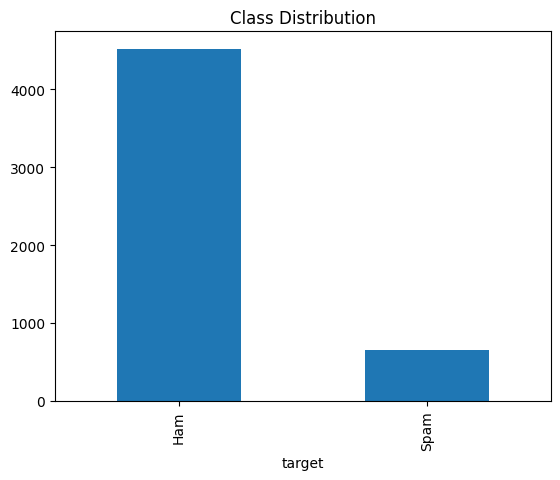

In [22]:

spam_df['target'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Ham', 'Spam'])
plt.title("Class Distribution")
plt.show()


In [24]:
spam_df['msg_length'] = spam_df['content'].apply(len)

spam_df.groupby('target')['msg_length'].mean()


/tmp/ipython-input-226065495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_df['msg_length'] = spam_df['content'].apply(len)


,msg_length
target,
0,70.459256
1,137.891271


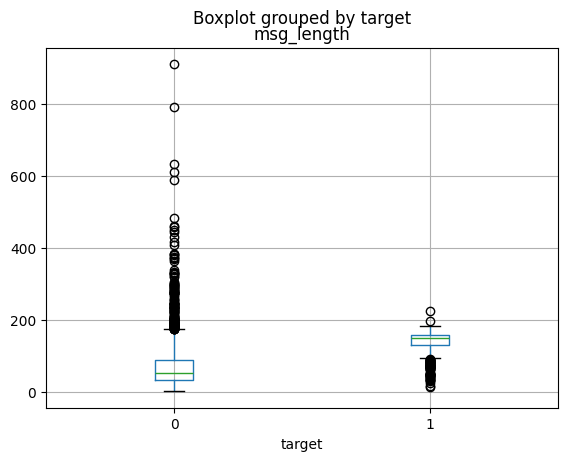

In [25]:
spam_df.boxplot(column='msg_length', by='target')
plt.show()


In [26]:
spam_df['word_count'] = spam_df['content'].apply(lambda x: len(x.split()))

spam_df.groupby('target')['word_count'].mean()


/tmp/ipython-input-3749086292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spam_df['word_count'] = spam_df['content'].apply(lambda x: len(x.split()))


,word_count
target,
0,14.134632
1,23.681470


In [29]:
from collections import Counter
import re

def get_words(text):
    text = re.sub(r'\W+', ' ', text.lower())
    return text.split()

spam_words = Counter()
ham_words = Counter()

for msg, label in zip(spam_df['content'], spam_df['target']):
    if label == 1:
        spam_words.update(get_words(msg))
    else:
        ham_words.update(get_words(msg))

spam_words.most_common(10)


[('to', 596),
 ('a', 332),
 ('call', 309),
 ('you', 268),
 ('å', 247),
 ('your', 242),
 ('free', 195),
 ('2', 184),
 ('for', 184),
 ('the', 183)]

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = spam_df['content']
y = spam_df['target']

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(X)


In [31]:
from scipy.sparse import hstack

numeric_features = spam_df[['msg_length', 'word_count']].values
X_final = hstack([X_tfidf, numeric_features])


In [32]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(score_func=chi2, k=3000)
X_selected = selector.fit_transform(X_final, y)


In [33]:
feature_names = tfidf.get_feature_names_out()
selected_features = feature_names[selector.get_support(indices=True)[:20]]
print(selected_features)


['00' '00 sub' '000' '000 bonus' '000 cash' '000 prize' '000 xmas'
 '008704050406' '008704050406 sp' '02' '02 06' '0207' '0207 153'
 '02073162414' '02073162414 costs' '021' '021 3680' '03' '03 05' '03 2nd']


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [44]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
pipelines = {
    'Logistic Regression': Pipeline([

        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([

        ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    ])
}

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200)

In [45]:
results = {}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"===== {name} =====")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    # Save metrics for comparison
    results[name] = {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score']
    }


===== Logistic Regression =====
Confusion Matrix:
[[890  13]
 [ 16 115]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       903
           1       0.90      0.88      0.89       131

    accuracy                           0.97      1034
   macro avg       0.94      0.93      0.94      1034
weighted avg       0.97      0.97      0.97      1034

===== Random Forest =====
Confusion Matrix:
[[901   2]
 [ 19 112]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.98      0.85      0.91       131

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [46]:
best_model = max(results, key=lambda x: results[x]['f1_score'])

print("\n===== Model Comparison =====")
for model, metrics in results.items():
    print(f"{model} -> Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-score: {metrics['f1_score']:.4f}")

print(f"\nBest model based on F1-score: {best_model}")



===== Model Comparison =====
Logistic Regression -> Precision: 0.9717, Recall: 0.9720, F1-score: 0.9718
Random Forest -> Precision: 0.9797, Recall: 0.9797, F1-score: 0.9791

Best model based on F1-score: Random Forest


In [47]:
import joblib

# Save the best pipeline
best_pipeline = pipelines[best_model]
joblib.dump(best_pipeline, 'best_sms_spam_model.pkl')

print(f"Best model '{best_model}' saved successfully as 'best_sms_spam_model.pkl'.")


Best model 'Random Forest' saved successfully as 'best_sms_spam_model.pkl'.


In [48]:
# Load the saved model
loaded_model = joblib.load('best_sms_spam_model.pkl')

# Test predictions
y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.98      0.85      0.91       131

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [51]:
import numpy as np

# Example messages
test_messages = [
    "Congratulations! You have won a $1000 gift card. Click here to claim.",
    "Hey, are we meeting for lunch today?",
    "Free entry in 2 a weekly competition to win cash!",
    "Please call me when you are free."
]

# Preprocess the test messages using the fitted TF-IDF vectorizer and feature engineering
X_test_tfidf = tfidf.transform(test_messages)

# Calculate numeric features for test messages
msg_length_test = [len(msg) for msg in test_messages]
word_count_test = [len(msg.split()) for msg in test_messages]
numeric_features_test = np.array(list(zip(msg_length_test, word_count_test)))

# Stack TF-IDF features with numeric features
X_test_processed = hstack([X_test_tfidf, numeric_features_test])

# Apply feature selection using the fitted selector
X_test_final = selector.transform(X_test_processed)

# Make predictions
predictions = loaded_model.predict(X_test_final)

# Print results
for msg, pred in zip(test_messages, predictions):
    prediction_label = 'Spam' if pred == 1 else 'Ham'
    print(f"Message: '{msg}'")
    print(f"Prediction: {prediction_label}")
    print("-"*50)

Message: 'Congratulations! You have won a $1000 gift card. Click here to claim.'
Prediction: Spam
--------------------------------------------------
Message: 'Hey, are we meeting for lunch today?'
Prediction: Ham
--------------------------------------------------
Message: 'Free entry in 2 a weekly competition to win cash!'
Prediction: Ham
--------------------------------------------------
Message: 'Please call me when you are free.'
Prediction: Ham
--------------------------------------------------
